## Muestreo de conglomerados (una etapa)
    - Un conglomerado es un conjunto de elementos de la población

    - El muestreo de conglomerados consiste en hacer un m.a.s. de éstos conjuntos para censar a los elementos dentro de ellos.
    
    - Se emplea debido a que posiblemente no exista un marco de los elementos de la poblaciñon. Es menos costoso cuando la distancia entre elementos incrementa el costo de la encuesta. Por ejemplo, es más fácil censar múltiples casas dentro de una manzana que hacer un m.a.s de casas dispersas por toda la ciudad. En el mismo ejemplo, es más fáctible que se tenga un marco de manzanas a que uno de casas
    
    - A diferencia del muestreo estratificado, en conglomerados se prefiere que existe heterogeneidad en los elementos dentro, es decir, que se maximice la varianza al interior y se minimice entre ellas.
    
    - Nomenclatura. Nota: Observe que no se considera m_i, pues se supone que cada conglomerado es censado.
        
        N: # de conglomerados en la población
        n: # de conglomerados en la muestra
        M_i: # total de elementos en el conglomerado i
        y_ij: Medición del elemento j en el conglomerado i
        mean: Media por conglomerado
        mean_i: Media por elemento del conglomerado i
        S_b^2: Varianza observada (between) entre conglomerados
        S_w_i^2: Varianza observada (within) dentro del conglomerado i
        
        

### Conclusiones
    - S_b^2 es la varianza entre conglomerados, la cuál mide que tan diferentes son cada conglomerados entre sí. Para que el muestreo por conglomerados sea bueno, se requiere que S_b^2 sea bajo.
    
    - Estimar el total por empleando conglomerados es dependiente de M_i, ya que si se tienen tamaños heterogeneos entre conglomerados, la estimación no será buena.
    
    - Los estimadores usuales de la media por elemento y total poblacional son insesgados, pero usualmente tienen varianzas grandes, por lo que se prefieren los estimadores de razón

### 1] Definir una población

In [581]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

# Settings
N = 25
n = 3
M = np.random.randint(low=5, high=21, size=N)
confidence = 0.95

# Define population dataframe
df_population = pd.DataFrame()
cluster = np.repeat([i for i in range(N)], M)
df_population["cluster"] = cluster
temporal = np.array([])
for i in range(N):
    temporal = np.concatenate((temporal, norm.rvs(loc=100,scale=25,size=M[i])))
df_population["value"] = temporal

# Force cluster mean around 100
mean = np.array(df_population.groupby(["cluster"]).mean())
goal = norm.rvs(loc=100,scale=2,size=N)
for i in range(N):
    df_population.loc[cluster==i,"value"] = (goal[i]/mean[i] *
        df_population.loc[cluster==i,"value"])
    
# Force mean by element equal to 100
df_population["value"] = 100/df_population["value"].mean(0) * df_population["value"]
df_population["proportion"] = np.where(df_population["value"] >= df_population["value"].mean(0),1,0)



# Output
print("="*100)
print("POPULATION")
print("\nMean:", np.round(df_population["value"].mean(0),2))
print("Total:", np.round(df_population["value"].sum(0),2))
print("Proportion:", np.round(df_population["proportion"].mean(0),2))
print("="*100)

POPULATION

Mean: 100.0
Total: 34400.0
Proportion: 0.49


[Text(0.5, 1.0, 'Heterogeneity within. Homogeneity between.')]

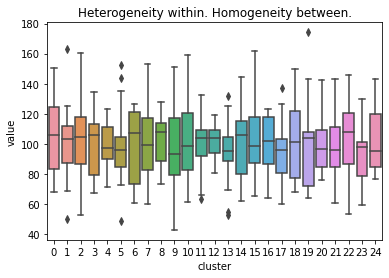

In [582]:
# Plot population
sns.boxplot(data=df_population, x="cluster", y="value").set(
            title="Heterogeneity within. Homogeneity between.")

### 2] Estimación con m.a.s.
    - Para fines comparativos

In [583]:
# Define sample size according to expected sample size in cluster sampling
M_mean = df_population.shape[0]/N
N_mas = df_population.shape[0]
n_mas = int(np.ceil(M_mean*n))

# Estimation of mean
df_sample = df_population.sample(n=n_mas, random_state=100)
mean = df_sample["value"].mean(0)
mean_var = (1-n_mas/N_mas) * df_sample["value"].var(0,ddof=1)/n_mas
mean_interval = mean + mean_var**0.5*norm.ppf((0.5-confidence/2,0.5+confidence/2))

# Estimation of total
total = N_mas * df_sample["value"].mean(0)
total_var = N_mas**2 * mean_var
total_interval = total + total_var**0.5*norm.ppf((0.5-confidence/2,0.5+confidence/2))

# Output
print("="*100)
print("SRS - Using elements")
print("\nMean: ", round(mean,2))
print("SE(Mean): ",round(mean_var**0.5,2))
print("CI(Mean): ", np.round(mean_interval,2))
print("\nTotal: ", round(total,2))
print("SE(Total): ",round(total_var**0.5,2))
print("CI(Total): ", np.round(total_interval,2))
print("="*100)

SRS - Using elements

Mean:  104.29
SE(Mean):  3.81
CI(Mean):  [ 96.82 111.76]

Total:  35874.86
SE(Total):  1310.85
CI(Total):  [33305.64 38444.08]


### 3] Estimación de la media por elemento y total poblacional
            
    - El estimador del total poblacional es:
    
        total = N * mean
            donde:
            N: Número total de conglomerados
            mean: Media del total por conglomerado
            
        mean = 1/n * sum[i in n][j in M_i](y_ij)
            donde:
            y_ij: Medición del elemento j del conglomerado i
            
        - Con varianza:

            V(total) = N^2 * (1-n/N) * 1/n * S_b^2 
                donde:
                S_b^2: Varianza entre (between) conglomerados

            S_b^2 = 1/(n-1) * sum[i in n]((y_i - mean)^2)
                donde:
                mean: Media del total por conglomerado
                y_i: Total observado del conglomerado i

    - Cuando se conoce el total poblacional M, la media por elemento se estima como:

        mean_e = 1/M * N/n * sum[i in n](y_i)
            donde:
            mean_e = Estimador de la media por elemento
            M: Total de elementos en la población
            y_i: Total observado en el conglomerado i
            
        - Con varianza:
            
            V(mean_e) = 1/M^2 * V(total)
                donde:
                V(total): Varianza del estimador del total

In [584]:
import random

# Select a sample
random.seed(100)
mask = random.sample([i for i in range(N)], n)
df_sample = df_population[df_population["cluster"].isin(mask)].copy()

# Estimate total
mean = 1/n * df_sample["value"].sum(0)
total = N * mean
S_b = df_sample.groupby(["cluster"]).sum(0).var(0,ddof=1)["value"]
total_var = N**2 * (1-n/N) * 1/n * S_b
total_interval = total + total_var**0.5*norm.ppf((0.5-confidence/2,0.5+confidence/2))

# Estimate mean by element
mean_e = 1/M.sum(0) * N/n * df_sample["value"].sum(0)
mean_e_var = 1/M.sum(0)**2 * total_var
mean_e_interval = mean_e + mean_e_var**0.5*norm.ppf((0.5-confidence/2,0.5+confidence/2))

# Output
print("="*100)
print("Cluster sampling - Usual estimators")
print("\nMean: ", round(mean_e,2))
print("SE(Mean): ",round(mean_e_var**0.5,2))
print("CI(Mean): ", np.round(mean_e_interval,2))
print("\nTotal: ", round(total,2))
print("SE(Total): ",round(total_var**0.5,2))
print("CI(Total): ", np.round(total_interval,2))
print("="*100)

Cluster sampling - Usual estimators

Mean:  100.37
SE(Mean):  35.41
CI(Mean):  [ 30.97 169.78]

Total:  34528.45
SE(Total):  12181.69
CI(Total):  [10652.77 58404.13]


### 4] Estimadores de razón
    - Para reducir la incertidumbre es preferible utilizar estimadores de razón, los cuales ajustan los resultados, pues estiman el total a la vez que el número de elementos dentro de cada conglomerado.
    
    - La media por elemento se estima como:
        
        mean_e = sum[i in n](y_i) / sum[i in n](M_i)
            donde:
            y_i: Total observado en el conglomerado i
            M_i: Número de elementos en el conglomerado i
        
    - Con varianza:
        
        V(mean_e) = (1-n/N) * 1/n * 1/M_m^2 * sum[i in n]( (y_i - mean_e*M_i)^2 / (n-1) )
            donde:
            M_m: Media observada del número de elementos en los conglomerados
            y_i: Total observado en el conglomerado i
            mean_e: Media por elemento calculada por razón
            M_i: Número de elementos en el conglomerado i
            
    - El total poblacional se estima como:
    
        total = M * mean_e
            donde:
            M: Total de elementos en la población
            mean_e: Estimador de la media por elemento
            
    - Con varianza:
    
        V(total) = M^2 * V(mean_e)
            donde:
            M: Total de elementos en la población
            V(mean_e): Calculada anteriormente

In [585]:
# Estimate mean by element
mean_e = df_sample["value"].sum(0) / df_sample.shape[0]
M_m = df_sample.groupby(["cluster"])["value"].count().mean(0)
sum_i = df_sample.groupby(["cluster"])["value"].sum()
count_i = df_sample.groupby(["cluster"])["value"].count()
mean_e_var = (1-n/N) * 1/n * 1/M_m**2 * ( (sum_i-mean_e*count_i)**2 / (n-1) ).sum()
mean_e_interval = mean_e + mean_e_var**0.5*norm.ppf((0.5-confidence/2,0.5+confidence/2))

# Estimate total
total = M.sum(0) * mean_e
total_var = M.sum(0)**2 * mean_e_var



# Output
print("="*100)
print("Cluster sampling - Ratio estimators")
print("\nMean: ", round(mean_e,2))
print("SE(Mean): ",round(mean_e_var**0.5,2))
print("CI(Mean): ", np.round(mean_e_interval,2))
print("\nTotal: ", round(total,2))
print("SE(Total): ",round(total_var**0.5,2))
print("CI(Total): ", np.round(total_interval,2))
print("="*100)

Cluster sampling - Ratio estimators

Mean:  98.65
SE(Mean):  1.01
CI(Mean):  [ 96.67 100.63]

Total:  33936.54
SE(Total):  347.59
CI(Total):  [10652.77 58404.13]


### 5] Tamaño de muestra

    - El tamaño de muestra sigue los estimadores usuales y no los de razón
    
    - Este cálculo se realiza a partir de una muestra piloto que permita calcular estimadores inciales
    
    - El tamaño de muestra, en número de estratos se define como:
    
        n = N*S_b^2 /( N*delta^2*M_m^2/z_c^2 + S_b^2)
            donde:
            delta: Precisión deseada
            z_c: Inversa de la normal para la confianza deseada
            M_m: Número de elementos promedio en los conglomerados
            S_b^2: Varianza entre (between) conglomerados

    - La precisión puede calcularse con la siguiente fórmula o puede darse como un número fijo.
    
        delta^2 = z_c^2 * (1/n-1/N) * 1/M_m^2 * S_b^2
            Nota: Observe que se pide n, que es lo que se quiere calcular, sin embargo, se refiere a
            la de la muestra piloto

In [604]:
# Previous code
z_c = norm.ppf(0.5+confidence/2)
M_m = df_sample.groupby(["cluster"])["value"].count().mean(0)
S_b = df_sample.groupby(["cluster"])["value"].sum(0).var(0,ddof=1)

# Calculate sample size
delta = 50
# delta = ( z_c**2 * (1/n-1/N) * 1/M_m**2 * S_b )**0.5
n_sample = N*S_b / ( N*delta**2*M_m**2 / z_c**2 + S_b )

# Output
print("="*100)
print("El número de conglomerados por muestrear es:",np.ceil(n_sample))
print("="*100)

El número de conglomerados por muestrear es: 4.0
